In [1]:
%matplotlib inline

from metapool.metapool import *

/Users/jonsanders/Development/anaconda/envs/py3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Workflow for normalizing DNA

This portion of the notebook will read in the output of the mini-Pico quantification assay and construct an Echo normalization picklist file. 

As inputs, it requires:
1. A tab-delimited row-wise plate map that indicates the sample name, well location, and blank status of each sample on the 384 well plate. 

The workflow then:
1. reads in the plate map and constructs a dataframe
2. calculates volumes to be added via echo to reach desired input DNA quantity
3. produces an Echo-formatted pick list file

In [202]:
# method to read in plate map and produce Pandas df

def read_plate_map_csv(f, sep = '\t'):
    """
    reads tab-delimited plate map into a Pandas dataframe

    Parameters
    ----------
    f: fp or open filehandle
        plate map file

    Returns
    -------
    plate_df: pandas DataFrame object
        DataFrame relating sample name, well location, and blank status
    """
    
    plate_df = pd.read_csv(f, sep = sep)
    plate_df['Well'] =  plate_df['Row'] + plate_df['Col'].map(str)
        
    return(plate_df)

plate_map_csv = \
"""
Sample\tRow\tCol\tBlank
sam1\tA\t1\tFalse
sam2\tA\t2\tFalse
blank1\tB\t1\tTrue
sam3\tB\t2\tFalse
"""

plate_map_f = StringIO(plate_map_csv)

exp_plate_df = pd.DataFrame({'Sample': ['sam1','sam2','blank1','sam3'],
                             'Row': ['A','A','B','B'],
                             'Col': [1,2,1,2],
                             'Well': ['A1','A2','B1','B2'],
                             'Blank': [False, False, True, False]})

obs_plate_df = read_plate_map_csv(plate_map_f)

pd.testing.assert_frame_equal(obs_plate_df, exp_plate_df, check_like=True)



# method to read minipico output
def read_pico_csv(f, sep='\t'):
    """
    reads tab-delimited pico quant

    Parameters
    ----------
    f: fp or open filehandle
        pico quant file
    sep: str
        sep char used in quant file

    Returns
    -------
    pico_df: pandas DataFrame object
        DataFrame relating well location and DNA concentration
    """
    
    raw_df = pd.read_csv(f, sep = sep, skiprows=2, skipfooter=5)
    
    pico_df = raw_df[['Well','[Concentration]']]
    pico_df.rename(columns={'[Concentration]':'Sample DNA Concentration'}, inplace=True)
    
    return(pico_df)


pico_csv = '''Results

Well ID\tWell\t[Blanked-RFU]\t[Concentration]
SPL1\tA1\t5243.000\t3.432
SPL2\tA2\t4949.000\t3.239
SPL3\tB1\t15302.000\t10.016
SPL4\tB2\t4039.000\t2.644

Curve2 Fitting Results

Curve Name\tCurve Formula\tA\tB\tR2\tFit F Prob
Curve2\tY=A*X+B\t1.53E+003\t0\t0.995\t?????
'''

pico_csv_f = StringIO(pico_csv)

obs_pico_df = read_pico_csv(pico_csv_f)

pd.testing.assert_frame_equal(obs_plate_df, exp_plate_df, check_like=True)


# method to calculate volumes
def calculate_norm_vol(dna_concs, ng=5, min_vol=2.5, max_vol=3500, resolution=2.5):
    """
    Calculates nanoliters of each sample to add to achieve a normalized pool

    Parameters
    ----------
    dna_concs : numpy array of float
        The concentrations calculated via PicoGreen (ng/uL)
    ng : float
        The amount of DNA to pool (ng)
    max_vol : float
        The maximum volume to pool (nL)
    min_vol : float
        The minimum volume to pool (nL)

    Returns
    -------
    sample_vols : numpy array of float
        The volumes to pool (nL)
    """
    sample_vols = ng / np.nan_to_num(dna_concs) * 1000
    
    sample_vols = np.clip(sample_vols, min_vol, max_vol)

    sample_vols = np.round(sample_vols / resolution) * resolution
    
    return(sample_vols)

dna_concs = np.array([[2, 7.89],
                      [np.nan, .0]])

exp_vols = np.array([[2500., 632.5],
                      [3500., 3500.]])

obs_vols = calculate_norm_vol(dna_concs)

np.testing.assert_allclose(exp_vols, obs_vols)



# method to generate pick list
def format_dna_norm_picklist(dna_vols, water_vols, wells, dna_concs=None, sample_names=None,
                             dna_plate_name='Sample', water_plate_name='Water',
                             dna_plate_type='384PP_AQ_SP2_HT', water_plate_type='384PP_AQ_SP2_HT',
                             dest_plate_name='NormalizedDNA'):
    """
    Writes Echo-format pick list to achieve a normalized input DNA pool

    Parameters
    ----------
    dna_vols:  numpy array of float
        The volumes of dna to add
    water_vols:  numpy array of float
        The volumes of water to add
    wells: numpy array of str
        The well codes in the same orientation as the DNA concentrations
    dna_concs:  numpy array of float
        The concentrations calculated via PicoGreen (ng/uL)
    sample_names: numpy array of str
        The sample names in the same orientation as the DNA concentrations
 
    Returns
    -------
    picklist : str
        The Echo formatted pick list
    """
    
    # check that arrays are the right size
    if dna_vols.shape != wells.shape != water_vols.shape:
        raise ValueError('dna_vols %r has a size different from wells %r or water_vols' %
                         (dna_vols.shape, wells.shape, water_vols.shape))
        
    if sample_names is None:
        sample_names = np.empty(dna_vols.shape) * np.nan
    if dna_concs is None:
        dna_concs = np.empty(dna_vols.shape) * np.nan
    if dna_concs.shape != sample_names.shape != dna_vols.shape:
        raise ValueError('dna_vols %r has a size different from dna_concs %r or sample_names' %
                         (dna_vols.shape, dna_concs.shape, sample_names.shape))
        
    picklist = ''
    
    # header
    picklist += 'Sample\tSource Plate Name\tSource Plate Type\tSource Well\tConcentration\t' \
                'Transfer Volume\tDestination Plate Name\tDestination Well'
    
    # water additions
    for index, sample in np.ndenumerate(sample_names):
        picklist += '\n' + '\t'.join([str(sample), water_plate_name, water_plate_type,
                               str(wells[index]), str(dna_concs[index]), str(water_vols[index]),
                               dest_plate_name, str(wells[index])]) 
    # DNA additions
    for index, sample in np.ndenumerate(sample_names):
        picklist += '\n' + '\t'.join([str(sample), dna_plate_name, dna_plate_type,
                               str(wells[index]), str(dna_concs[index]), str(dna_vols[index]),
                               dest_plate_name, str(wells[index])])    
    
    return(picklist)


exp_picklist = \
'''Sample\tSource Plate Name\tSource Plate Type\tSource Well\tConcentration\tTransfer Volume\tDestination Plate Name\tDestination Well
sam1\tWater\t384PP_AQ_SP2_HT\tA1\t2.0\t1000.0\tNormalizedDNA\tA1
sam2\tWater\t384PP_AQ_SP2_HT\tA2\t7.89\t2867.5\tNormalizedDNA\tA2
blank1\tWater\t384PP_AQ_SP2_HT\tB1\tnan\t0.0\tNormalizedDNA\tB1
sam3\tWater\t384PP_AQ_SP2_HT\tB2\t0.0\t0.0\tNormalizedDNA\tB2
sam1\tSample\t384PP_AQ_SP2_HT\tA1\t2.0\t2500.0\tNormalizedDNA\tA1
sam2\tSample\t384PP_AQ_SP2_HT\tA2\t7.89\t632.5\tNormalizedDNA\tA2
blank1\tSample\t384PP_AQ_SP2_HT\tB1\tnan\t3500.0\tNormalizedDNA\tB1
sam3\tSample\t384PP_AQ_SP2_HT\tB2\t0.0\t3500.0\tNormalizedDNA\tB2'''

dna_vols = np.array([[2500., 632.5],
                      [3500., 3500.]])

water_vols = 3500 - dna_vols

wells = np.array([['A1', 'A2'],
                  ['B1', 'B2']])

sample_names =  np.array([['sam1', 'sam2'],
                  ['blank1', 'sam3']])

dna_concs = np.array([[2, 7.89],
                      [np.nan, .0]])

obs_picklist = format_dna_norm_picklist(dna_vols, water_vols, wells,
                                        sample_names = sample_names,
                                        dna_concs = dna_concs)

assert(exp_picklist == obs_picklist)


dna_vols = np.array([[2500., 632.5,
                      3500., 3500.]])

water_vols = 3500 - dna_vols

wells = np.array([['A1', 'A2',
                   'B1', 'B2']])

sample_names =  np.array([['sam1', 'sam2',
                           'blank1', 'sam3']])

dna_concs = np.array([[2, 7.89,
                      np.nan, .0]])

obs_picklist = format_dna_norm_picklist(dna_vols, water_vols, wells,
                                        sample_names = sample_names,
                                        dna_concs = dna_concs)

assert(exp_picklist == obs_picklist)

/Users/jonsanders/Development/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:63: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
/Users/jonsanders/Development/anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/frame.py:2844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/Users/jonsanders/Development/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:113: RuntimeWarning: divide by zero encountered in true_divide


In [214]:
# Step 1: read in plate map

plate_df = read_plate_map_csv(open('./test_data/MRSA/Map/MRSA_sample_map.txt','r'))

# Step 2: read in DNA concentrations and add to plate map

sample_concs = read_pico_csv(open('./test_data/MRSA/Quant/MiniPico/2017-08-01_MRSA_1-4.txt','r'))
plate_df = pd.merge(plate_df, sample_concs, on='Well')

# Step 3: calculate volumes and add to plate map
dna_vols = calculate_norm_vol(plate_df['Sample DNA Concentration'], ng=5, min_vol=2.5, max_vol=3500, resolution=2.5)
water_vols = 3500 - dna_vols
plate_df['Normalized DNA volume'] = dna_vols
plate_df['Normalized water volume'] = water_vols

# Step 4: make pick list
obs_picklist = format_dna_norm_picklist(np.array(plate_df['Normalized DNA volume']),
                                        np.array(plate_df['Normalized water volume']),
                                        np.array(plate_df['Well']),
                                        sample_names = np.array(plate_df['Sample']),
                                        dna_concs = np.array(plate_df['Sample DNA Concentration']))

# Step 5: write pick list to file
with open('./test_output/MRSA/2017-08-04_MRSA_1-4_DNA_norm_picklist.txt', 'w') as f:
    f.write(obs_picklist)

/Users/jonsanders/Development/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:63: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
/Users/jonsanders/Development/anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/frame.py:2844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [240]:
# assign indices
def assign_index(samples, index_df, start_idx=0):
    """
    Writes Echo-format pick list to achieve a normalized input DNA pool

    Parameters
    ----------
    samples:  int
        The number of samples for which to get indices 
    index_df:  pandas DataFrame
        The dataframe of complete index combinations and information
    start_idx: int
        The starting index combo to use
 
    Returns
    -------
    indices : pandasDataFrame
        The index information for the chosen indices
    """
    
    indices = index_df.iloc[start_idx:(start_idx + samples)]
    
    return(indices)


# method to generate pick list
def format_index_picklist(sample_names, sample_wells, indices,
                          i5_vol=250, i7_vol=250,
                          i5_plate_type='384LDV_AQ_B2_HT', i7_plate_type='384LDV_AQ_B2_HT',
                          dest_plate_name='IndexPCRPlate'):
    """
    Writes Echo-format pick list to achieve a normalized input DNA pool

    Parameters
    ----------
    sample_names:  array-like of str
        The sample names matching index order of indices
    sample_wells:  array-like of str
        The wells matching sample name order
    indices: pandas DataFrame
        The dataframe with index info matching sample_names
 
    Returns
    -------
    picklist : str
        The Echo formatted pick list
    """
    
    # check that arrays are the right size
    if len(sample_names) != len(sample_wells) != len(indices):
        raise ValueError('sample_names (%s) has a size different from sample_wells (%s) or index list (%s)' %
                         (len(sample_names), len(sample_wells), len(indices)))
            
    picklist = ''
    
    # header
    picklist += 'Sample\tSource Plate Name\tSource Plate Type\tSource Well\tTransfer Volume\t' \
                'Index Name\tIndex Sequence\tIndex Combo\tDestination Plate Name\tDestination Well'
    
    # i5 additions
    for i, (sample, well) in enumerate(zip(sample_names, sample_wells)):
        picklist += '\n' + '\t'.join([str(sample), indices.iloc[i]['i5 plate'], i5_plate_type,
                                      indices.iloc[i]['i5 well'], str(i5_vol), indices.iloc[i]['i5 name'],
                                      indices.iloc[i]['i5 sequence'], str(indices.iloc[i]['index combo']),
                                      dest_plate_name, well])
    # i7 additions
    for i, (sample, well) in enumerate(zip(sample_names, sample_wells)):
        picklist += '\n' + '\t'.join([str(sample), indices.iloc[i]['i7 plate'], i7_plate_type,
                                      indices.iloc[i]['i7 well'], str(i7_vol), indices.iloc[i]['i7 name'],
                                      indices.iloc[i]['i7 sequence'], str(indices.iloc[i]['index combo']),
                                      dest_plate_name, well]) 
    
    return(picklist)


exp_picklist = \
'''Sample\tSource Plate Name\tSource Plate Type\tSource Well\tTransfer Volume\tIndex Name\tIndex Sequence\tIndex Combo\tDestination Plate Name\tDestination Well
sam1\tiTru5_plate\t384LDV_AQ_B2_HT\tA1\t250\tiTru5_01_A\tACCGACAA\t0\tIndexPCRPlate\tA1
sam2\tiTru5_plate\t384LDV_AQ_B2_HT\tB1\t250\tiTru5_01_B\tAGTGGCAA\t1\tIndexPCRPlate\tA2
blank1\tiTru5_plate\t384LDV_AQ_B2_HT\tC1\t250\tiTru5_01_C\tCACAGACT\t2\tIndexPCRPlate\tB1
sam3\tiTru5_plate\t384LDV_AQ_B2_HT\tD1\t250\tiTru5_01_D\tCGACACTT\t3\tIndexPCRPlate\tB2
sam1\tiTru7_plate\t384LDV_AQ_B2_HT\tA1\t250\tiTru7_101_01\tACGTTACC\t0\tIndexPCRPlate\tA1
sam2\tiTru7_plate\t384LDV_AQ_B2_HT\tA2\t250\tiTru7_101_02\tCTGTGTTG\t1\tIndexPCRPlate\tA2
blank1\tiTru7_plate\t384LDV_AQ_B2_HT\tA3\t250\tiTru7_101_03\tTGAGGTGT\t2\tIndexPCRPlate\tB1
sam3\tiTru7_plate\t384LDV_AQ_B2_HT\tA4\t250\tiTru7_101_04\tGATCCATG\t3\tIndexPCRPlate\tB2'''

sample_wells = np.array(['A1', 'A2', 'B1', 'B2'])

sample_names =  np.array(['sam1', 'sam2', 'blank1', 'sam3'])

indices = pd.DataFrame({'i5 name': {0: 'iTru5_01_A',
                       1: 'iTru5_01_B',
                       2: 'iTru5_01_C',
                       3: 'iTru5_01_D'},
         'i5 plate': {0: 'iTru5_plate',
                      1: 'iTru5_plate',
                      2: 'iTru5_plate',
                      3: 'iTru5_plate'},
         'i5 sequence': {0: 'ACCGACAA', 1: 'AGTGGCAA',
                         2: 'CACAGACT', 3: 'CGACACTT'},
         'i5 well': {0: 'A1', 1: 'B1', 2: 'C1', 3: 'D1'},
         'i7 name': {0: 'iTru7_101_01',
                     1: 'iTru7_101_02',
                     2: 'iTru7_101_03',
                     3: 'iTru7_101_04'},
         'i7 plate': {0: 'iTru7_plate',
                      1: 'iTru7_plate',
                      2: 'iTru7_plate',
                      3: 'iTru7_plate'},
         'i7 sequence': {0: 'ACGTTACC', 1: 'CTGTGTTG',
                         2: 'TGAGGTGT', 3: 'GATCCATG'},
         'i7 well': {0: 'A1', 1: 'A2', 2: 'A3', 3: 'A4'},
         'index combo': {0: 0, 1: 1, 2: 2, 3: 3},
         'index combo seq': {0: 'ACCGACAAACGTTACC',
                             1: 'AGTGGCAACTGTGTTG',
                             2: 'CACAGACTTGAGGTGT',
                             3: 'CGACACTTGATCCATG'}})

obs_picklist = format_index_picklist(sample_names, sample_wells, indices)

assert(exp_picklist == obs_picklist)


# Workflow for assigning barcodes

This portion of the notebook will assign index values and construct an Echo picklist file for adding barcodes. 

As inputs, it requires:
1. A plate map dataframe (from previous step) **or** A tab-delimited row-wise plate map\
2. A tab-delimited index combination file, relating index combinations, i5 and i7 index values, and i5 and i7 index locations

The workflow then:
1. reads in the plate map or dataframe
2. reads in the index combo list
3. produces an Echo-formatted pick list file

In [55]:
# # read in plate map

# plate_df = read_plate_map_csv(open('./test_data/MRSA/Map/MRSA_sample_map.txt','r'))

In [215]:
# Read in index combo list

index_combo_fp = '/Users/jonsanders/Dropbox/Documents/Research/Postdoc/Knight_Lab/EMP500/metagenomics_prep/adapters/new_iTru_combos.csv'
index_combos = pd.read_csv(index_combo_fp)

In [243]:
# Assign index combo

indices = assign_index(len(plate_df['Sample']), index_combos, start_idx=0)

In [244]:
# Make index pick list

index_picklist = format_index_picklist(plate_df['Sample'], plate_df['Well'], indices)

In [246]:
# Step 5: write pick list to file
with open('./test_output/MRSA/2017-08-04_MRSA_1-4_index_picklist.txt', 'w') as f:
    f.write(index_picklist)

# Workflow for calculating pooling

This notebook calculates pooling based on qPCR values, and produces visual outputs to interpret and check values. 

As inputs, this notebook requires:
1. qPCR output (tab-delimited text format with columns 'Cp' and 'Pos'
2. DNA input normalization pick list (comma-delimited text format Echo pick list used for DNA normalization)
3. Unique indices pick list (CSV text format Echo pick list, including sample names, used for index primer addition)

The workflow:
1. reads in qPCR output and calculates estimated library concentration
2. reads in DNA concentrations and graphs library concentration against DNA concentration
3. reads in indices and sample names and plots library concentration across plates
4. calculates pooling values and generates an Echo pick list

## Step 1: read in input files

Before the workflow starts, we'll provide the paths to each of the three input files in one location. 

**Enter the correct path to the file**, and then you can execute the following steps:

In [2]:
qpcr_input_fp = './test_data/MRSA/Quant/qPCR/2017-08-04_MRSA_1-4.txt'
dna_picklist_fp = './test_data/MRSA/Input_Normalization/2017_08_04_MRSA_1-4_input_norm.csv'
index_picklist_fp = './test_data/MRSA/Indices/Primer_Combination1_MRSA1-4.csv'

for file in [qpcr_input_fp, dna_picklist_fp, index_picklist_fp]:
    if not os.path.isfile(file):
        print("Problem! %s is not a path to a valid file" % file)

### Read in qPCR output. 

This file should look something like this:

```
Experiment: 2017-05-19_Knight_CF+ABTX+AGP_KHP_rerun  Selected Filter: SYBR Green I / HRM Dye (465-510)
Include	Color	Pos	Name	Cp	Concentration	Standard	Status
True	255	A1	Sample 1	20.55		0	
True	255	A2	Sample 2	  9.15		0	
True	255	A3	Sample 3	  9.16		0	
True	255	A4	Sample 4	  8.89		0	
True	255	A5	Sample 5	  8.43		0	
True	255	A6	Sample 6	  8.66		0	
True	255	A7	Sample 7	  8.84		0	
True	255	A8	Sample 8	  8.85		0
```

In [3]:
qpcr_df = pd.read_csv(qpcr_input_fp, sep = '\t', skiprows=1, header=0)
qpcr_df.head()

,Include,Color,Pos,Name,Cp,Concentration,Standard,Status
0,True,255,A1,Sample 1,14.20,NaN,0,NaN
1,True,255,A2,Sample 2,16.19,NaN,0,NaN
2,True,255,A3,Sample 3,15.87,NaN,0,NaN
3,True,255,A4,Sample 4,17.75,NaN,0,NaN
4,True,255,A5,Sample 5,15.42,NaN,0,NaN


### Read in DNA norm pick list. 

This file should look something like this:

```
Source Plate Name,Source Plate Type,Source Well,Concentration,Transfer Volume,Destination Plate Name,Destination Well
water,384LDV_AQ_B2_HT,A1,,3420,NormalizedDNA,A1
water,384LDV_AQ_B2_HT,C1,,3442.5,NormalizedDNA,C1
water,384LDV_AQ_B2_HT,E1,,3477.5,NormalizedDNA,E1
water,384LDV_AQ_B2_HT,G1,,3322.5,NormalizedDNA,G1
water,384LDV_AQ_B2_HT,I1,,3142.5,NormalizedDNA,I1
water,384LDV_AQ_B2_HT,K1,,3330,NormalizedDNA,K1
water,384LDV_AQ_B2_HT,M1,,3345,NormalizedDNA,M1
water,384LDV_AQ_B2_HT,O1,,3477.5,NormalizedDNA,O1
water,384LDV_AQ_B2_HT,A3,,3447.5,NormalizedDNA,A3
```

In [4]:
dna_picklist = pd.read_csv(dna_picklist_fp, sep = ',', header = 0)
dna_picklist.loc[384:389]

,Source Plate Name,Source Plate Type,Source Well,Concentration,Transfer Volume,Destination Plate Name,Destination Well
384,1,384PP_AQ_SP2_HT,A1,3.432,1457.5,NormalizedDNA,A1
385,1,384PP_AQ_SP2_HT,C1,3.239,1545.0,NormalizedDNA,C1
386,1,384PP_AQ_SP2_HT,E1,10.016,500.0,NormalizedDNA,E1
387,1,384PP_AQ_SP2_HT,G1,2.644,1892.5,NormalizedDNA,G1
388,1,384PP_AQ_SP2_HT,I1,8.419,595.0,NormalizedDNA,I1
389,1,384PP_AQ_SP2_HT,K1,1.859,2692.5,NormalizedDNA,K1


### Read in index pick list.

This file should look something like this:

```
Well Number,Plate,Sample Name,Source Plate Name,Source Plate Type,Counter,Primer,Source Well,Index,,,,Transfer volume,Destination Well,
1,ABTX_35,8_29_13_rk_rh,iTru Source Plate,384LDV_AQ_B2_HT,1841,iTru5_01_G,G1,GTTCCATG,iTru7_110_05,A23,CGCTTAAC,250,A1,
2,ABTX_35,8_29_13_rk_lh,iTru Source Plate,384LDV_AQ_B2_HT,1842,iTru5_01_H,H1,TAGCTGAG,iTru7_110_06,B23,CACCACTA,250,C1,
3,ABTX_35,8_30_13_rk_fh,iTru Source Plate,384LDV_AQ_B2_HT,1843,iTru5_02_A,I1,CTTCGCAA,iTru7_110_07,C23,ACAGCAAC,250,E1,
4,ABTX_35,8_30_13_rk_rh,iTru Source Plate,384LDV_AQ_B2_HT,1844,iTru5_02_B,J1,GTGGTATG,iTru7_110_08,D23,GGAAGGAT,250,G1,
5,ABTX_35,8_30_13_rk_lh,iTru Source Plate,384LDV_AQ_B2_HT,1845,iTru5_02_C,K1,CACTGTAG,iTru7_110_09,E23,GGCGTTAT,250,I1,
6,ABTX_35,8_31_13_rk_lh,iTru Source Plate,384LDV_AQ_B2_HT,1846,iTru5_02_D,L1,AGACGCTA,iTru7_110_10,F23,CTGTTGAC,250,K1,
7,ABTX_35,8_31_13_rk_fh,iTru Source Plate,384LDV_AQ_B2_HT,1847,iTru5_02_E,M1,CAACTCCA,iTru7_110_11,G23,GTCATCGA,250,M1,
8,ABTX_35,8_31_13_rk_rh,iTru Source Plate,384LDV_AQ_B2_HT,1848,iTru5_02_F,N1,AACACGCT,iTru7_110_12,H23,TGACTTCG,250,O1,
9,ABTX_35,9_1_13_rk_rh,iTru Source Plate,384LDV_AQ_B2_HT,1849,iTru5_02_G,O1,TGGATGGT,iTru7_111_01,I23,CGATAGAG,250,A3,
```

In [5]:
index_picklist = pd.read_csv(index_picklist_fp, sep = ',', header = 0)
index_picklist.head()

,Well Number,Plate,Sample Name,Source Plate Name,Source Plate Type,Counter,Primer,Source Well,Index,Unnamed: 9,Unnamed: 10,Unnamed: 11,Transfer volume,Destination Well
0,1,1,GLY_01_012,i5 Source Plate,384LDV_AQ_B2_HT,1,iTru5_01_A,A1,ACCGACAA,iTru7_109_01,A22,CTCGTCTT,250,A1
1,2,1,GLY_11_007,i5 Source Plate,384LDV_AQ_B2_HT,2,iTru5_01_B,B1,AGTGGCAA,iTru7_109_02,B22,CGAACTGT,250,C1
2,3,1,GLY_25_003,i5 Source Plate,384LDV_AQ_B2_HT,3,iTru5_01_C,C1,CACAGACT,iTru7_109_03,C22,CATTCGGT,250,E1
3,4,1,GLY_07_011,i5 Source Plate,384LDV_AQ_B2_HT,4,iTru5_01_D,D1,CGACACTT,iTru7_109_04,D22,TCGGTTAC,250,G1
4,5,1,GLY_28_004,i5 Source Plate,384LDV_AQ_B2_HT,5,iTru5_01_E,E1,GACTTGTG,iTru7_109_05,E22,AAGTCGAG,250,I1


## Step 2: merge sample information

This step will merge the information from each of the three files into a single data frame. 

In [6]:
combined_df = combine_dfs(qpcr_df, dna_picklist, index_picklist)
combined_df.head()

,Well,Cp,DNA Concentration,DNA Transfer Volume,Sample Name,Plate,Counter,Source Well i7,Index i7,Primer i7,Source Well i5,Index i5,Primer i5
0,A1,14.20,3.432,1457.5,GLY_01_012,1,1,A22,CTCGTCTT,iTru7_109_01,A1,ACCGACAA,iTru5_01_A
1,A2,16.19,3.036,1647.5,GLY_14_017,2,97,A22,CTCGTCTT,iTru7_109_01,C1,CACAGACT,iTru5_01_C
2,A3,15.87,3.633,1377.5,GLY_02_011,1,9,I22,AGTCGCTT,iTru7_109_09,I1,CTTCGCAA,iTru5_02_A
3,A4,17.75,4.061,1232.5,GLY_15_018,2,105,I22,AGTCGCTT,iTru7_109_09,K1,CACTGTAG,iTru5_02_C
4,A5,15.42,3.612,1385.0,GLY_03_011,1,17,A23,CGCTTAAC,iTru7_110_05,A2,AACACCAC,iTru5_03_A


## Step 3: calculate sample concentration

This step will calculate the estimated concentration based on Cp value. It will also add this info back to the sample data frame.

In [7]:
combined_df['Library Concentration'] = compute_qpcr_concentration(combined_df['Cp'])
combined_df.head()

,Well,Cp,DNA Concentration,DNA Transfer Volume,Sample Name,Plate,Counter,Source Well i7,Index i7,Primer i7,Source Well i5,Index i5,Primer i5,Library Concentration
0,A1,14.20,3.432,1457.5,GLY_01_012,1,1,A22,CTCGTCTT,iTru7_109_01,A1,ACCGACAA,iTru5_01_A,5.436218
1,A2,16.19,3.036,1647.5,GLY_14_017,2,97,A22,CTCGTCTT,iTru7_109_01,C1,CACAGACT,iTru5_01_C,1.316402
2,A3,15.87,3.633,1377.5,GLY_02_011,1,9,I22,AGTCGCTT,iTru7_109_09,I1,CTTCGCAA,iTru5_02_A,1.653595
3,A4,17.75,4.061,1232.5,GLY_15_018,2,105,I22,AGTCGCTT,iTru7_109_09,K1,CACTGTAG,iTru5_02_C,0.433078
4,A5,15.42,3.612,1385.0,GLY_03_011,1,17,A23,CGCTTAAC,iTru7_110_05,A2,AACACCAC,iTru5_03_A,2.278793


## Step 4: calculate pooling values

This step will calculate the sample pooling, and update the sample data frame with the pool info.

You can change some variables if you want different behavior:

- **min_conc**: This is the minimum concentration for a sample to be considered for pooling. Set to 0 to pool all samples, regardless of concentration. Increasing this will have the effect of increasing pool concentration, at the expense of samples dropping out. 
- **floor_conc**: This is the lowest concentration equivalent for which a sample will be accurately pooled. Samples below this concentration will be pooled to the volume that they would have been if they were actually that concentration. For example, if `floor_conc=20`, and a sample at 20 nM pools at 500 nL, a sample at 40 nM will pool at 250 nL but a sample at 10 nM will still pool at 500 nL (rather than 1000). Increasing this value will have the effect of increasing pool concentration, but decreasing read counts for low-concentration samples. 
- **total_nmol**: This is the total number of molecules to shoot for in the pool. Increasing this will increase the overall volume of the pool. 

In [8]:
combined_df['Pooled Volume'] = compute_shotgun_pooling_values_qpcr(np.nan_to_num(combined_df['Library Concentration']),
                                        min_conc=20, floor_conc=40,
                                        total_nmol=.008)
combined_df.head()

,Well,Cp,DNA Concentration,DNA Transfer Volume,Sample Name,Plate,Counter,Source Well i7,Index i7,Primer i7,Source Well i5,Index i5,Primer i5,Library Concentration,Pooled Volume
0,A1,14.20,3.432,1457.5,GLY_01_012,1,1,A22,CTCGTCTT,iTru7_109_01,A1,ACCGACAA,iTru5_01_A,5.436218,0.0
1,A2,16.19,3.036,1647.5,GLY_14_017,2,97,A22,CTCGTCTT,iTru7_109_01,C1,CACAGACT,iTru5_01_C,1.316402,0.0
2,A3,15.87,3.633,1377.5,GLY_02_011,1,9,I22,AGTCGCTT,iTru7_109_09,I1,CTTCGCAA,iTru5_02_A,1.653595,0.0
3,A4,17.75,4.061,1232.5,GLY_15_018,2,105,I22,AGTCGCTT,iTru7_109_09,K1,CACTGTAG,iTru5_02_C,0.433078,0.0
4,A5,15.42,3.612,1385.0,GLY_03_011,1,17,A23,CGCTTAAC,iTru7_110_05,A2,AACACCAC,iTru5_03_A,2.278793,0.0


The estimated pool volume and concentration are (concentration, nM; volume, nL):

In [9]:
estimate_pool_conc_vol(combined_df['Pooled Volume'], combined_df['Library Concentration'])

(131.41005992200289, 59707.054726445087)

## Step 5: visualization

This step will present visuals of the results, including:
1. Scatter plot of DNA concentrations by Library concentration
2. Plate-wise heatmap and histogram showing library concentrations
3. per-96-well plate heatmaps and histograms showing library concentrations and sample names
4. Plate-wise heatmap showing pooling values

### Library concentration by sample DNA concentration:

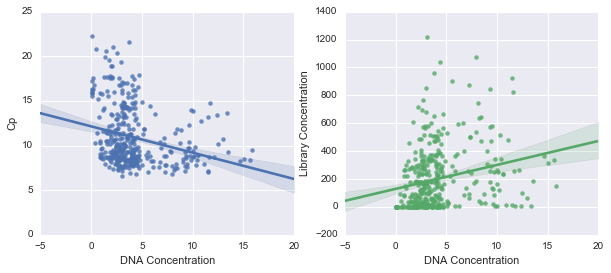

In [10]:
f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.regplot(x="DNA Concentration", y="Cp", data=combined_df, ax = ax1);
sns.regplot(x="DNA Concentration", y="Library Concentration", data=combined_df, ax = ax2);

### Library concentration heatmap, whole plate

In [11]:
# get concentration and pooling values for plotting
concs = make_2D_array(combined_df, data_col="Library Concentration", well_col='Well').astype(float)
vols = make_2D_array(combined_df, data_col='Pooled Volume', well_col='Well').astype(float)
dna = make_2D_array(combined_df, data_col='DNA Concentration', well_col='Well').astype(float)

# get information for annotation
names = make_2D_array(combined_df, data_col='Sample Name', well_col='Well')
i5 = make_2D_array(combined_df, data_col='Primer i5', well_col='Well')
i7 = make_2D_array(combined_df, data_col='Primer i7', well_col='Well')

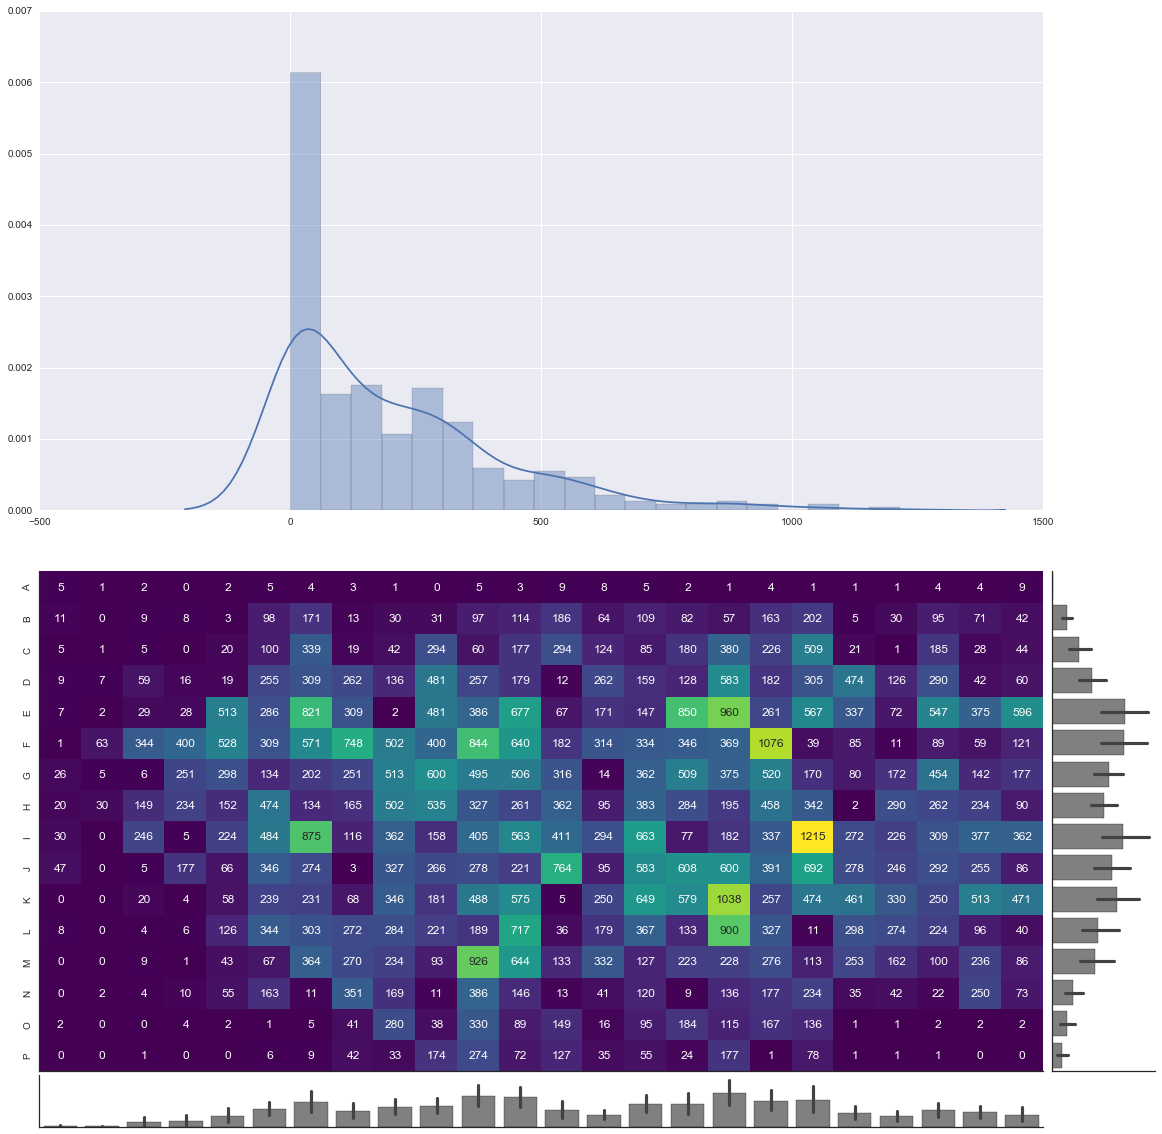

In [13]:
plot_plate_vals(concs, color_map='viridis')

### Plate maps for individual constituent plates

In [14]:
# Make mask arrays for even and odd rows and columns

even_rows = [x for x in range(16) if x % 2 == 0]
odd_rows = [x for x in range(16) if x % 2 == 1]
even_cols = [x for x in range(24) if x % 2 == 0]
odd_cols = [x for x in range(24) if x % 2 == 1]

### Library concentration heatmap, Plate 1

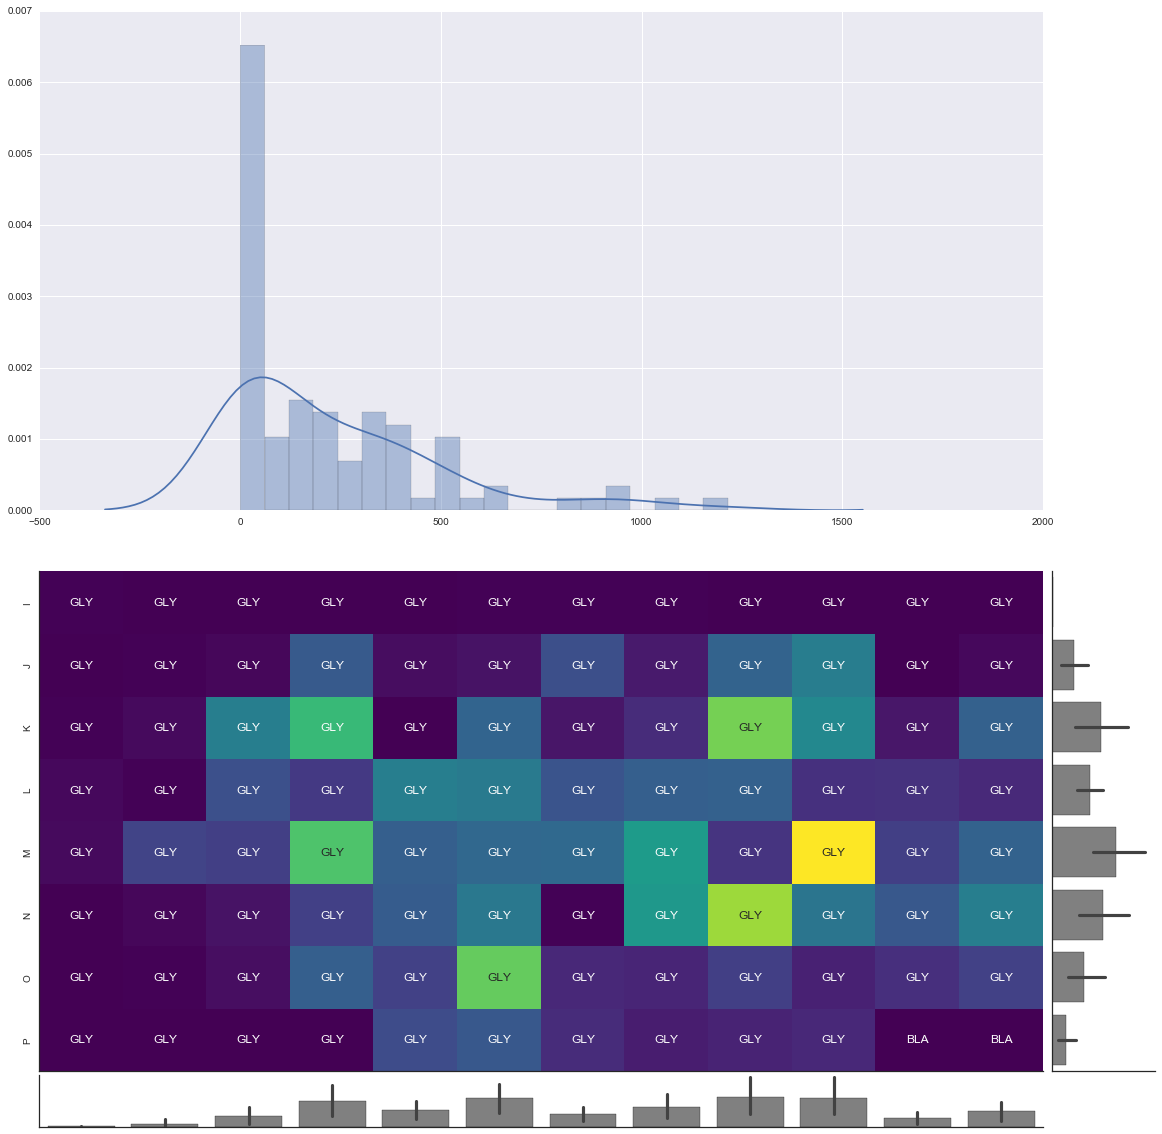

In [157]:
plot_plate_vals(concs[np.ix_(even_rows,even_cols)],
                annot_str= names[np.ix_(even_rows,even_cols)],
                color_map='viridis',
                annot_fmt='.3s')

### Library concentration heatmap, Plate 2

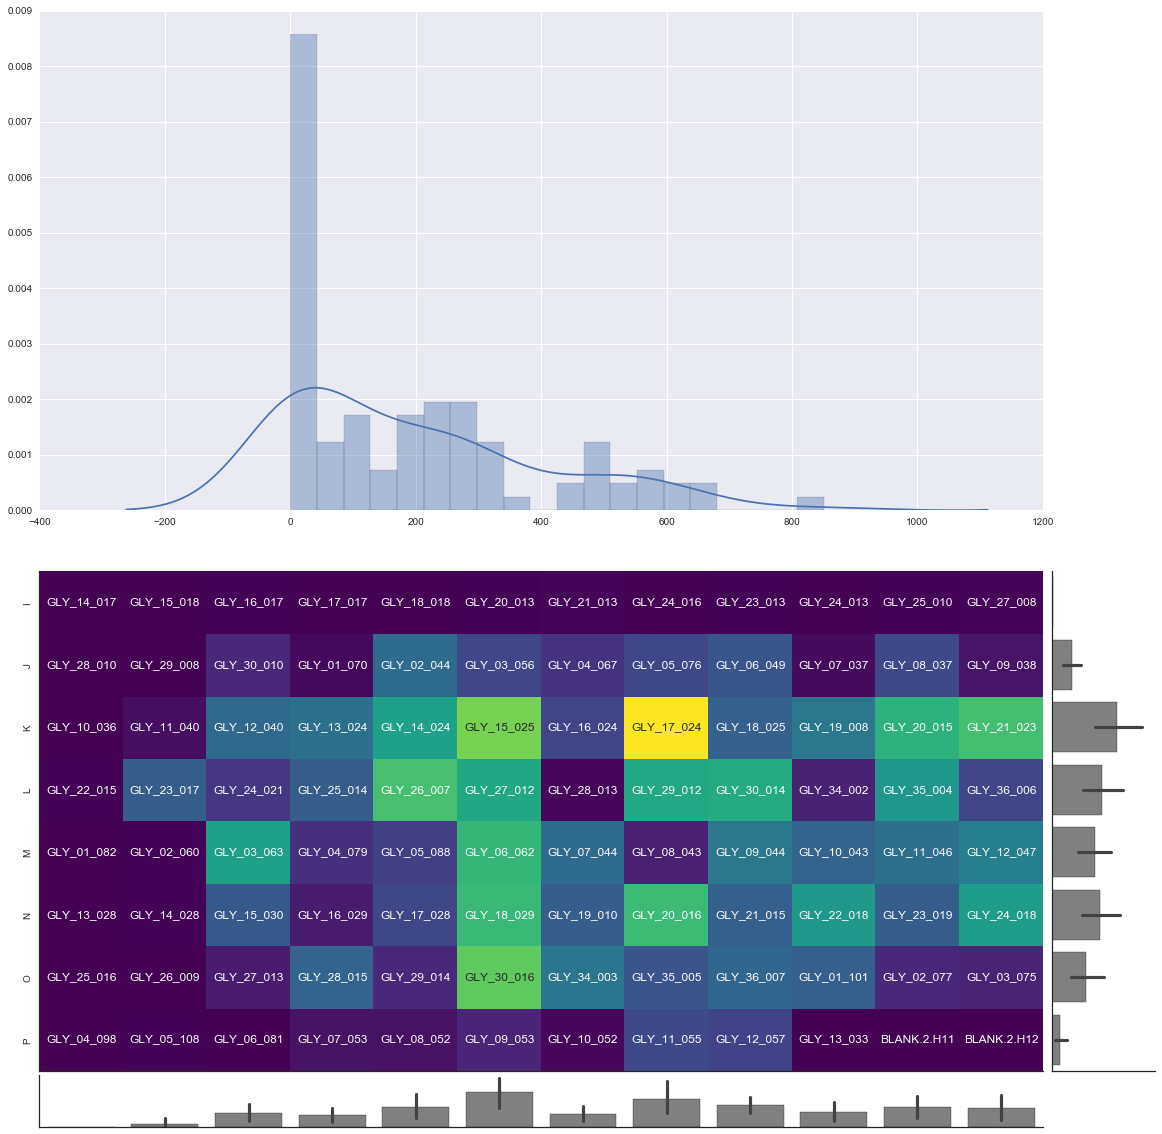

In [16]:
plot_plate_vals(concs[np.ix_(even_rows,odd_cols)],
                annot_str=names[np.ix_(even_rows,odd_cols)],
                color_map='viridis',
                annot_fmt='')

### Library concentration heatmap, Plate 3

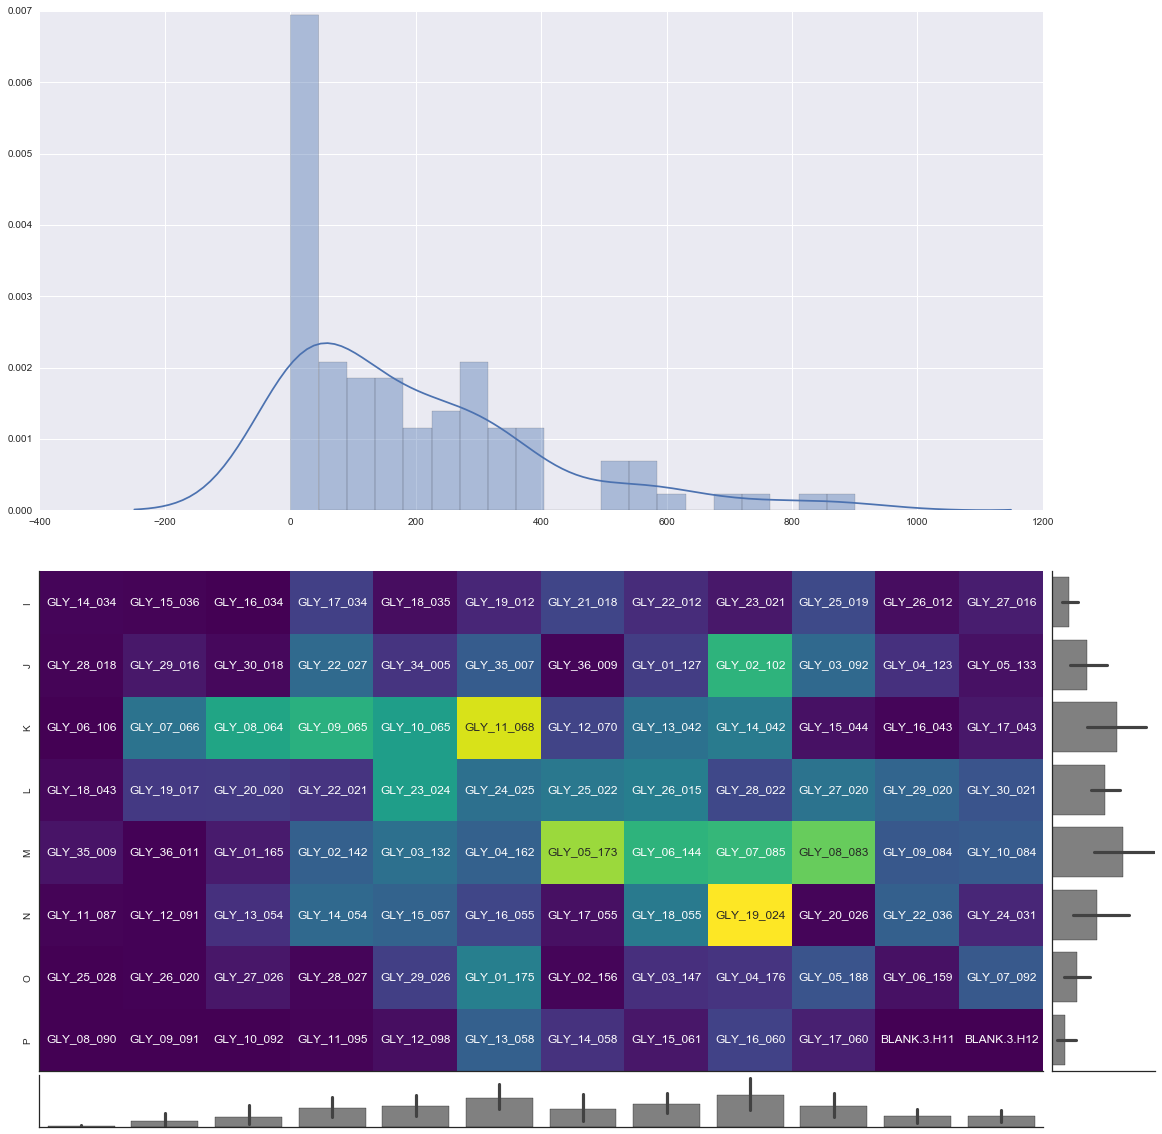

In [20]:
plot_plate_vals(concs[np.ix_(odd_rows, even_cols)],
                annot_str=names[np.ix_(odd_rows, even_cols)],
                color_map='viridis',
                annot_fmt='')

### Library concentration heatmap, Plate 4

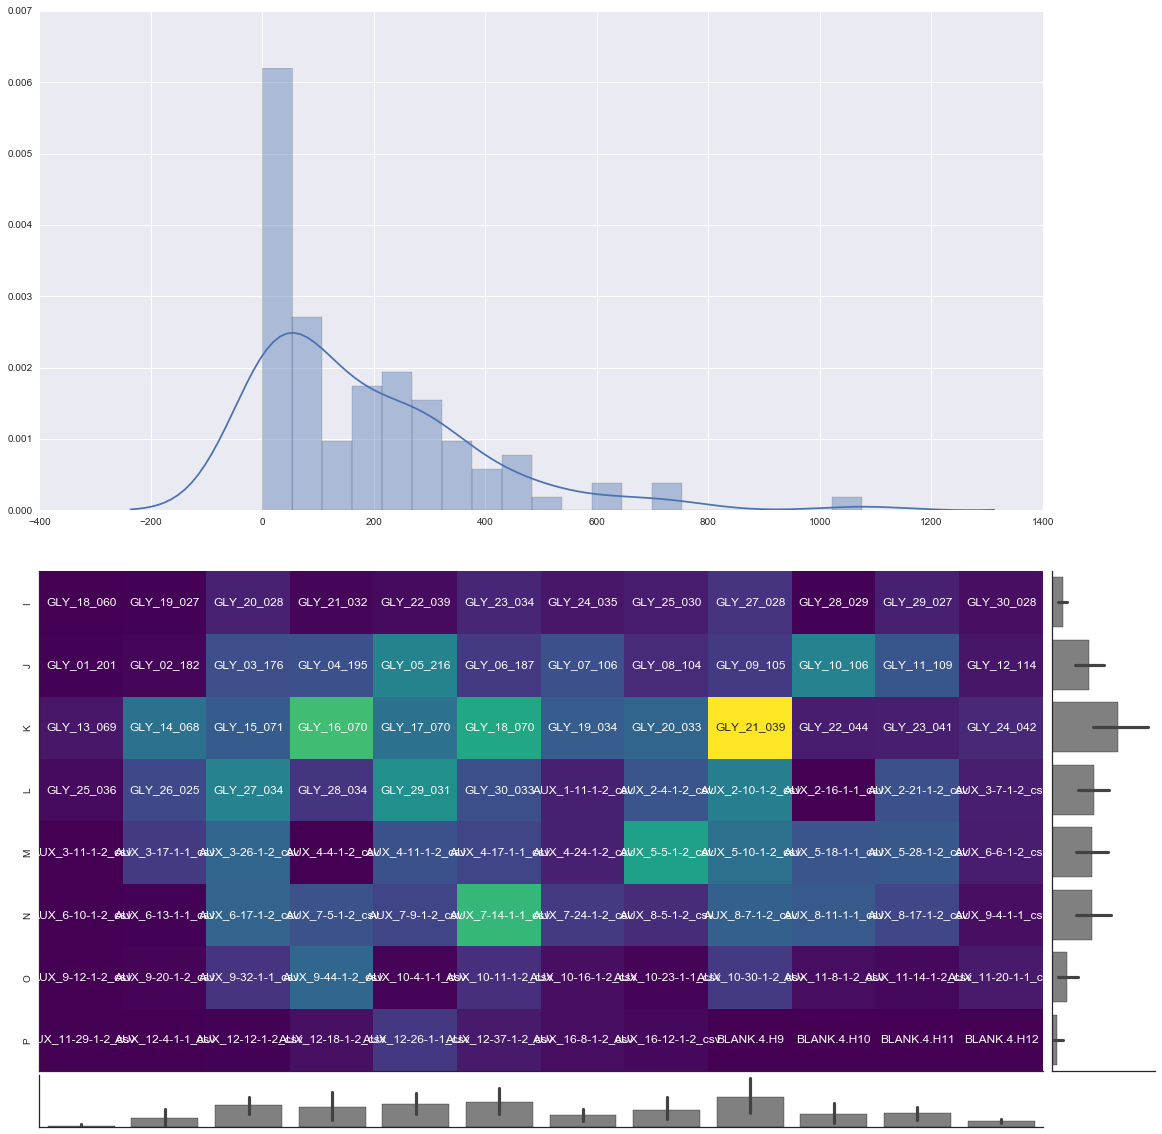

In [21]:
plot_plate_vals(concs[np.ix_(odd_rows, odd_cols)],
                annot_str=names[np.ix_(odd_rows, odd_cols)],
                color_map='viridis',
                annot_fmt='')

### Plot pooling volumes

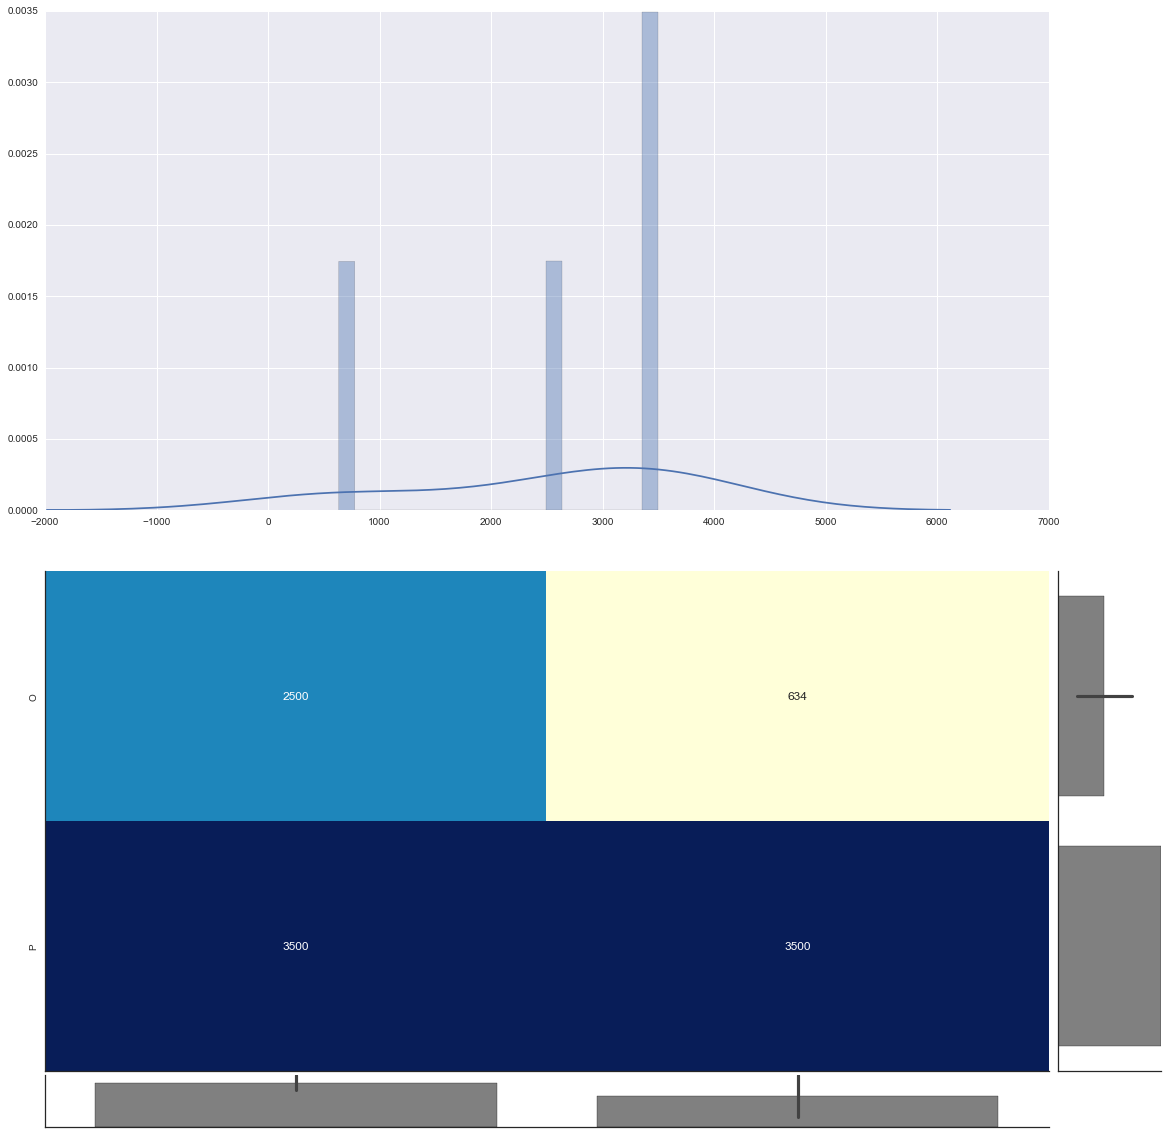

In [159]:
plot_plate_vals(vols)

## Step 6: write pooling pick list

In [23]:
# Write the picklist
picklist_fp = './test_output/MRSA/2017-08-04_MRSA_1-4_qPCR_pooling_picklist.txt'

if os.path.isfile(picklist_fp):
    print("Warning! This file exists already.")

In [24]:
picklist = format_pooling_echo_pick_list(vols, max_vol_per_well=30000)
with open(picklist_fp,'w') as f:
    f.write(picklist)
print(picklist)

Source Plate Name,Source Plate Type,Source Well,Concentration,Transfer Volume,Destination Plate Name,Destination Well
1,384LDV_AQ_B2_HT,A1,,0.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A2,,0.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A3,,0.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A4,,0.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A5,,0.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A6,,0.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A7,,0.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A8,,0.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A9,,0.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A10,,0.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A11,,0.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A12,,0.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A13,,0.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A14,,0.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A15,,0.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A16,,0.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A17,,0.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A18,,0.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A19,,0.00,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A20,,0.00,Normaliz